In [20]:
import pandas as pd
import numpy as np

In [21]:
L='nktr aig luv pch wdc nclh celg dwdp spxc ame xyl stt r akam reg dov xray chd apc'.upper().split(' ')

Merge the price data the same way as the quote and ask data, while for the size variable we sum over each 10 second period.

In [3]:
df=pd.read_csv('11011116_vwap.csv',header=0)


C:\Users\DR\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def VWAP_calc(ticker,capital):
    df_t=df[df['SYM_ROOT']==ticker]
    D=list(set(df_t['DATE']))
    St=[]
    S_t=[]
    for d in D[:-1]:
        i=-1
        s=[]
        T=[]
        df_d=df_t[df_t['DATE']==d]
        for j in range(len(df_d['TIME_M'])):
            
            if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
                    s.append(0)
                   
            if np.array(df_d['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_d['TIME_M'])[j][:-13])
                s.append(np.array(df_d['SIZE'])[j])
            else:
                s[i]+=np.array(df_d['SIZE'])[j]
        if '9:30' not in T:
            s=[0]+s
            
        if len(s)==30:
            St+=s
            S_t.append(s)
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    hist_mean=np.mean(S_t,axis=0)
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    #print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    #print(vol_mean)
    df_d=df_t[df_t['DATE']==D[0]]
    T=[]
    s_start=[]
    p_start=[]
    i=-1
    for j in range(len(df_d['TIME_M'])):
        
        if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
            
                s_start.append(0)
                p_start.append(p_start[-1])
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            
            i+=1
            T.append(str(np.array(df_d['TIME_M'])[j][:-13]))
            p_start.append(np.array(df_d['PRICE'])[j])
            s_start.append(np.array(df_d['SIZE'])[j])
        else:
            s_start[i]+=np.array(df_d['SIZE'])[j]
    if '9:30' not in T:
        s_start=[0]+s_start
        p_start=[0]+p_start
    df_d=df_t[df_t['DATE']==D[-1]]
    T=[]
    s_end=[]
    p_end=[]
    i=-1
    for j in range(len(df_d['TIME_M'])):
        
        if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
           
                s_end.append(0)
                p_end.append(p_end[-1])
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            i+=1
            T.append(str(np.array(df_d['TIME_M'])[j][:-13]))
            p_end.append(np.array(df_d['PRICE'])[j])
            s_end.append(np.array(df_d['SIZE'])[j])
        else:
            s_end[i]+=np.array(df_d['SIZE'])[j]
    if '9:30' not in T:
        s_end=[0]+s_end
        p_end=[0]+p_end
    #print(T)
    Dict_=np.load('data.npy').item()
    p_d=np.array(Dict_[ticker.lower()]['Close'])[22]
    cap=capital
    size=int(cap/p_d)
    hb,r,pb=execution(hist_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps=execution(hist_mean,size,s_end,p_end)
    size=int(cap/p_d)
    hb,r,pb2=execution(pred_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps2=execution(pred_mean,size,s_end,p_end)
    h,bb=benchmark(size,s_start,p_start)
    h,bs=benchmark(size,s_end,p_end)
    print('2018.11.01 (Buy)Executed VWAP(historic mean):'+str(round(pb,3))+' Executed VWAP(fitted mean):'+str(round(pb2,3))+' Benchmark VWAP:'+str(round(bb,3)))
    print('2018.11.16 (Sell)Executed VWAP(historic mean):'+str(round(ps,3))+' Executed VWAP(fitted mean):'+str(round(ps2,3))+' Benchmark VWAP:'+str(round(bs,3)))
    return St,(size*ps-size*pb)/(size*pb),hb,hs,pb,ps,bb,bs

In [48]:
for i in L:
  
    print(i)
    record=VWAP_calc(i,100000)

NKTR
2018.11.01 (Buy)Executed VWAP(historic mean):39.069 Executed VWAP(fitted mean):39.104 Benchmark VWAP:39.009
2018.11.16 (Sell)Executed VWAP(historic mean):38.213 Executed VWAP(fitted mean):38.186 Benchmark VWAP:38.229
AIG
2018.11.01 (Buy)Executed VWAP(historic mean):43.22 Executed VWAP(fitted mean):43.233 Benchmark VWAP:43.325
2018.11.16 (Sell)Executed VWAP(historic mean):42.544 Executed VWAP(fitted mean):42.544 Benchmark VWAP:42.485
LUV
2018.11.01 (Buy)Executed VWAP(historic mean):49.544 Executed VWAP(fitted mean):49.548 Benchmark VWAP:49.522
2018.11.16 (Sell)Executed VWAP(historic mean):52.715 Executed VWAP(fitted mean):52.707 Benchmark VWAP:52.68
PCH
2018.11.01 (Buy)Executed VWAP(historic mean):36.476 Executed VWAP(fitted mean):36.517 Benchmark VWAP:36.456
2018.11.16 (Sell)Executed VWAP(historic mean):36.489 Executed VWAP(fitted mean):36.491 Benchmark VWAP:36.199
WDC
2018.11.01 (Buy)Executed VWAP(historic mean):43.802 Executed VWAP(fitted mean):43.828 Benchmark VWAP:43.823
2018.

In [34]:
def execution(target_percentage,size,real_volume,real_price):
    i=0
    VWAP=0
    size_=size
    history=[]
    while size>0 and i<len(real_volume):
        goal=target_percentage[i]*size_
        if i==len(real_volume)-1:
            
            realized=min(size,real_volume[i])
        else:
            realized=min(goal,real_volume[i])
        realized=min(realized,size)
        VWAP+=realized*real_price[i]
        history.append(realized)
        
        i+=1
        size-=realized
    history=np.array(history)
    return history,size,VWAP/float(np.sum(history))
def benchmark(size,real_volume,real_price):
    history=np.array(real_volume)*size/float(sum(real_volume))
    VWAP=np.sum(history*np.array(real_price))
    return history,VWAP/float(np.sum(history))


In [39]:

try:    
    df_t=df[df['SYM_ROOT']==L[0]]
    D=list(set(df_t['DATE']))
    St=[]
    S_t=[]
    for d in D[:-1]:
        i=-1
        s=[]
        T=[]
        df_d=df_t[df_t['DATE']==d]
        for j in range(len(df_d['TIME_M'])):
            
            if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
                    s.append(0)
                   
            if np.array(df_d['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_d['TIME_M'])[j][:-13])
                s.append(np.array(df_d['SIZE'])[j])
            else:
                s[i]+=np.array(df_d['SIZE'])[j]
        if '9:30' not in T:
            s=[0]+s
            
        if len(s)==30:
            St+=s
            S_t.append(s)
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    #print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    vol_mean=np.mean(S_t,axis=0)
except:
    pass


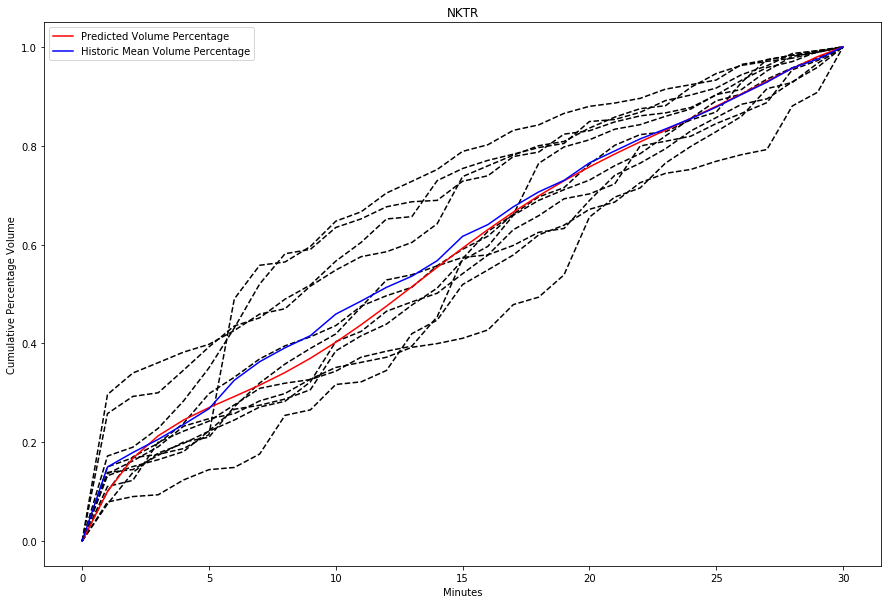

In [41]:
from matplotlib import pyplot as plt
%matplotlib inline
def plot_cumper(St,mean,pred,name):
    plt.figure(figsize=(15,10))
    for i in range(len(St)):
        c=[0]+[np.sum(St[i,:j+1]) for j in range(len(St[i]))]
        plt.plot(c,'k--')
    c=[0]+[np.sum(pred[:j+1]) for j in range(len(pred))]
    plt.plot(c,'r',label='Predicted Volume Percentage')
    c=[0]+[np.sum(mean[:j+1]) for j in range(len(mean))]
    plt.plot(c,'b',label='Historic Mean Volume Percentage')
    plt.title(name)
    plt.xlabel('Minutes')
    plt.ylabel('Cumulative Percentage Volume')
    plt.legend()
plot_cumper(S_t,vol_mean,pred_mean,L[0])